**<h2 style="text-align: center; color:#33FF33;">CHURN WITH NON-PURCHASE USERS</h2>**

#### **Neccessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix, classification_report,
    confusion_matrix, roc_curve, auc,
    brier_score_loss
)
import warnings

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Read and explore data**

#### **Read data**

In [2]:
df_login=pd.read_csv("../EDA_transform/data/login_transform.csv",dtype={'vopenid':'object'},parse_dates=['last_update_time'])
df_purchase=pd.read_csv("../EDA_transform/data/purchase_transform.csv",dtype={'vopenid':'object'})
df_equip=pd.read_csv("../EDA_transform/data/equipenhance_transform.csv",dtype={'vopenid':'object'})

df_purchase.columns = df_purchase.columns.str.strip()
df_equip.columns = df_equip.columns.str.strip()
df_purchase['last_update_time'] = pd.to_datetime(df_purchase['last_update_time'], errors='coerce', utc=True)
df_equip['last_update_time'] = pd.to_datetime(df_equip['last_update_time'], errors='coerce', utc=True)

df_login.shape,df_purchase.shape,df_equip.shape

((199370, 17), (32120, 9), (55138, 5))

In [3]:
df_login.info(),df_login['last_update_time'].min(),df_login['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199370 entries, 0 to 199369
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   vopenid                199370 non-null  object             
 1   last_update_time       199370 non-null  datetime64[ns, UTC]
 2   num_day_login          199370 non-null  int64              
 3   avg_login_per_day      199370 non-null  float64            
 4   avg_between_login      199370 non-null  float64            
 5   streak_login           199370 non-null  int64              
 6   last_since_from_login  199370 non-null  int64              
 7   popular_time_login     199370 non-null  int64              
 8   gold_std_login         199370 non-null  float64            
 9   diamond_std_login      199370 non-null  float64            
 10  silkcoin_std_login     199370 non-null  float64            
 11  gold_slope_login       199370 non-null 

(None,
 Timestamp('2025-05-03 17:01:25+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:59+0000', tz='UTC'))

In [4]:
df_purchase.info(),df_purchase['last_update_time'].min(),df_purchase['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32120 entries, 0 to 32119
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   vopenid                   32120 non-null  object             
 1   last_update_time          32040 non-null  datetime64[ns, UTC]
 2   num_purchase              32120 non-null  int64              
 3   total_purchase            32120 non-null  float64            
 4   count_purchase_per_day    32120 non-null  float64            
 5   std_amount_purchase       32120 non-null  float64            
 6   max_purchase              32120 non-null  float64            
 7   days_since_last_purchase  32120 non-null  int64              
 8   num_product_buyed         32120 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(3), object(1)
memory usage: 2.2+ MB


(None,
 Timestamp('2025-05-03 17:06:56.892000+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:55.790000+0000', tz='UTC'))

In [5]:
df_equip.info(),df_equip['last_update_time'].min(),df_equip['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55138 entries, 0 to 55137
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   vopenid               55138 non-null  object             
 1   last_update_time      55138 non-null  datetime64[ns, UTC]
 2   num_enhance           55138 non-null  int64              
 3   enhance_success_rate  55138 non-null  float64            
 4   max_enhance_level     55138 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(1)
memory usage: 2.1+ MB


(None,
 Timestamp('2025-05-03 17:00:34+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:58+0000', tz='UTC'))

#### **Merge data**

In [4]:
df_login = df_login.rename(columns={'last_update_time': 'last_update_time_login'})
df_purchase = df_purchase.rename(columns={'last_update_time': 'last_update_time_purchase'})
df_equip = df_equip.rename(columns={'last_update_time': 'last_update_time_equip'})

df_non_purchase_user = df_login[~df_login['vopenid'].isin(df_purchase['vopenid'])].copy()

df_merged = df_non_purchase_user.merge(
    df_equip.drop(columns=['last_update_time_equip']),
    on='vopenid',
    how='left'
)

In [5]:
del df_login
del df_purchase
del df_equip

In [6]:
df_merged.head(3)

,vopenid,last_update_time_login,num_day_login,avg_login_per_day,avg_between_login,streak_login,last_since_from_login,popular_time_login,gold_std_login,diamond_std_login,silkcoin_std_login,gold_slope_login,diamond_slope_login,silkcoin_slope_login,powerpoint_last_login,level_last_login,vip_last_login,num_enhance,enhance_success_rate,max_enhance_level
0,2206111754266455,2025-05-08 11:08:20+00:00,2,1.00,1.02,2,39,10,12632.46,0.00,0.00,17865.00,0.00,0.00,29366,9,0,NaN,NaN,NaN
1,2206111758351763,2025-05-26 05:07:07+00:00,1,1.00,0.00,1,21,5,0.00,0.00,0.00,0.00,0.00,0.00,25359,1,0,NaN,NaN,NaN
2,2206111808105074,2025-06-16 02:01:16+00:00,2,3.00,0.09,2,0,1,191511.83,0.41,0.00,61253.34,-0.14,0.00,74275,21,0,2.00,1.00,2.00


In [7]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167266 entries, 0 to 167265
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   vopenid                 167266 non-null  object             
 1   last_update_time_login  167266 non-null  datetime64[ns, UTC]
 2   num_day_login           167266 non-null  int64              
 3   avg_login_per_day       167266 non-null  float64            
 4   avg_between_login       167266 non-null  float64            
 5   streak_login            167266 non-null  int64              
 6   last_since_from_login   167266 non-null  int64              
 7   popular_time_login      167266 non-null  int64              
 8   gold_std_login          167266 non-null  float64            
 9   diamond_std_login       167266 non-null  float64            
 10  silkcoin_std_login      167266 non-null  float64            
 11  gold_slope_login        16

#### **Set churn**

In [10]:
now = pd.Timestamp('2025-06-19 17:00:00', tz='UTC')
df_merged['days_since_last_login'] = (now - df_merged['last_update_time_login']).dt.days

In [11]:
df_merged['last_update_time_login'].min(),df_merged['last_update_time_login'].max()

(Timestamp('2025-05-03 17:26:29+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:59+0000', tz='UTC'))

In [12]:
df_merged['churn'] = (df_merged['days_since_last_login'] >= 7).astype(int) # true is one
df_merged[['vopenid','last_update_time_login','churn']].head(10)

,vopenid,last_update_time_login,churn
0,2206211830166192,2025-05-26 03:29:48+00:00,1
1,2210221534402190,2025-06-18 14:17:29+00:00,0
2,2210221828089318,2025-06-17 18:38:11+00:00,0
3,2302080453545458,2025-06-18 07:15:50+00:00,0
4,2302141307530184,2025-06-12 12:50:04+00:00,1
5,2302201232124760,2025-06-18 15:18:02+00:00,0
6,2309230721167301,2025-06-11 14:24:20+00:00,1
7,2310030708237246,2025-06-18 06:46:13+00:00,0
8,2312031227360360,2025-06-18 14:21:35+00:00,0
9,2312250012396360,2025-06-13 09:56:33+00:00,0


In [13]:
df_merged['churn'].value_counts()

churn
0    28989
1     3115
Name: count, dtype: int64

In [14]:
df_merged.columns

Index(['vopenid', 'last_update_time_purchase', 'num_purchase',
       'total_purchase', 'count_purchase_per_day', 'std_amount_purchase',
       'max_purchase', 'days_since_last_purchase', 'num_product_buyed',
       'last_update_time_login', 'num_day_login', 'avg_login_per_day',
       'avg_between_login', 'streak_login', 'last_since_from_login',
       'popular_time_login', 'gold_std_login', 'diamond_std_login',
       'silkcoin_std_login', 'gold_slope_login', 'diamond_slope_login',
       'silkcoin_slope_login', 'powerpoint_last_login', 'level_last_login',
       'vip_last_login', 'num_enhance', 'enhance_success_rate',
       'max_enhance_level', 'days_since_last_login', 'churn'],
      dtype='object')

#### **Visualize**

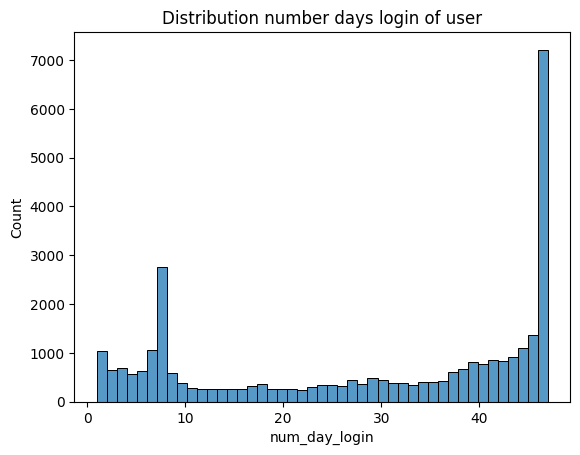

In [15]:
sns.histplot(df_merged['num_day_login'], bins=45)
plt.title('Distribution number days login of user')
plt.show()

In [16]:
df_merged['last_update_time_login'].min(),df_merged['last_update_time_login'].max()

(Timestamp('2025-05-03 17:26:29+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:59+0000', tz='UTC'))

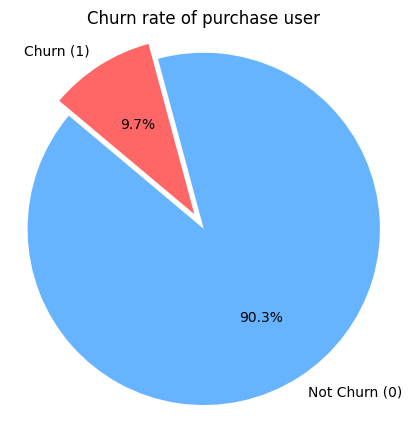

In [17]:
churn_counts = df_merged['churn'].value_counts().sort_index()
labels = ['Not Churn (0)', 'Churn (1)']
colors = ['#66b3ff', '#ff6666']

plt.figure(figsize=(5,5))
plt.pie(
    churn_counts, 
    labels=labels, 
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=[0, 0.1]  
)
plt.title("Churn rate of purchase user")
plt.axis('equal') 
plt.show()

In [18]:
drop_cols = [
    'last_update_time_purchase',
    'last_update_time_login',
    'days_since_last_purchase',
    'days_since_last_login',
]
df_merged=df_merged.drop(columns=drop_cols,axis=1)

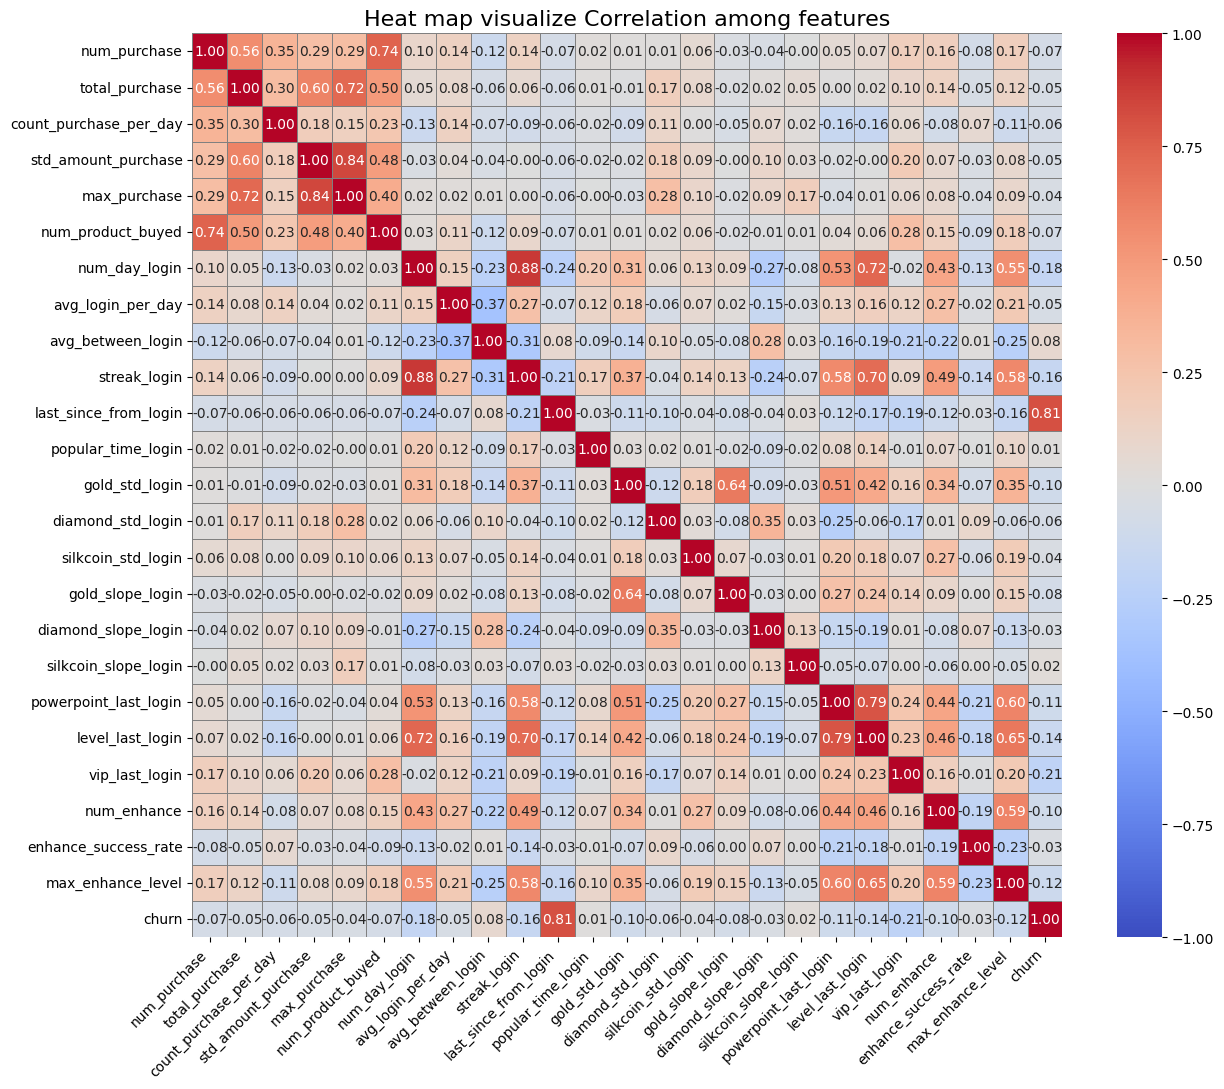

In [19]:
corr_cols = df_merged.drop(columns=['vopenid']).columns

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(13, 11))
sns.heatmap(
    corr_matrix,
    annot=True,        
    fmt=".2f",
    cmap="coolwarm",    
    vmin=-1,           
    vmax=1,
    center=0,        
    linewidths=0.5,     
    linecolor='gray' 
)

plt.title('Heat map visualize Correlation among features', fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
# corr_matrix = df_merged[corr_cols].corr()
# corr_matrix

### **Prepare data**

In [21]:
df_merged['num_enhance'] = df_merged['num_enhance'].fillna(0)
df_merged['enhance_success_rate'] = df_merged['enhance_success_rate'].fillna(0)
df_merged['max_enhance_level'] = df_merged['max_enhance_level'].fillna(0)

In [22]:
X=df_merged.drop(columns=['churn','vopenid','last_since_from_login','powerpoint_last_login'],axis=1)
y=df_merged['churn']

In [23]:
vopenid_all = df_merged['vopenid']

In [24]:
X_temp, X_train, y_temp, y_train, vopenid_temp, vopenid_train = train_test_split(
    X, y, vopenid_all,
    test_size=0.8, shuffle=False,
    stratify=y
)

X_test, X_val, y_test, y_val, vopenid_test, vopenid_val = train_test_split(
    X_temp, y_temp, vopenid_temp,
    test_size=0.5, shuffle=False,
    stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, vopenid_train.shape, vopenid_test.shape

ValueError: Stratified train/test split is not implemented for shuffle=False

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### **Modeling**

#### **Logistic Regression**

In [ ]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.001, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42
    }
    model = LogisticRegression(**params,class_weight='balanced')
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best AUC:", study.best_value)
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-23 15:02:06,535] A new study created in memory with name: no-name-acbdb0b7-363f-4335-8f38-441df0e0a58e
[I 2025-06-23 15:02:06,682] Trial 0 finished with value: 0.770280072944222 and parameters: {'C': 0.01743674549251834, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.770280072944222.
[I 2025-06-23 15:02:08,342] Trial 1 finished with value: 0.7700231193371928 and parameters: {'C': 1.7382209460664175, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.770280072944222.
[I 2025-06-23 15:02:10,035] Trial 2 finished with value: 0.7706145826954771 and parameters: {'C': 0.147431135921461, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.7706145826954771.
[I 2025-06-23 15:02:10,792] Trial 3 finished with value: 0.7597358882992878 and parameters: {'C': 0.001159611889277004, 'penalty': 'l2', 'solver': 'saga', 'class_weight': None}. Best is trial 2 

Best AUC: 0.7733146976155285
  - C: 0.020000271956604004
  - penalty: l1
  - solver: liblinear
  - class_weight: None


In [ ]:
best_params_lr = study.best_params
best_params_lr.update({
    'random_state': 42,
    'n_jobs': -1
})
lr_model = LogisticRegression(**best_params_lr,class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.020000271956604004, n_jobs=-1, penalty='l1',
                   random_state=42, solver='liblinear')

In [ ]:
y_test_pred  = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9321
Precision: 0.3902
Recall: 0.0766
F1-score: 0.1280
AUC-ROC: 0.7997
Log loss: 0.2210
Brier score: 0.0601

Confusion matrix:
[[2976   25]
 [ 193   16]]

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3001
           1       0.39      0.08      0.13       209

    accuracy                           0.93      3210
   macro avg       0.66      0.53      0.55      3210
weighted avg       0.90      0.93      0.91      3210



#### **Extra Trees**

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = ExtraTreesClassifier(**params,class_weight='balanced')
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-23 15:02:22,787] A new study created in memory with name: no-name-8233b1a9-10c9-4ae2-aa22-c3095c7fb46a
[I 2025-06-23 15:02:24,708] Trial 0 finished with value: 0.8795573550457816 and parameters: {'n_estimators': 375, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 13, 'max_features': 0.5, 'class_weight': None}. Best is trial 0 with value: 0.8795573550457816.
[I 2025-06-23 15:02:26,132] Trial 1 finished with value: 0.861380627837875 and parameters: {'n_estimators': 306, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 18, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8795573550457816.
[I 2025-06-23 15:02:27,838] Trial 2 finished with value: 0.8821154986370908 and parameters: {'n_estimators': 306, 'max_depth': 24, 'min_samples_split': 19, 'min_samples_leaf': 19, 'max_features': 0.5, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8821154986370908.
[I 2025-06-23 15:02:29,903] Trial 3 finished with value: 

Best value: 0.8916284356810802
Best params:
  - n_estimators: 481
  - max_depth: 26
  - min_samples_split: 11
  - min_samples_leaf: 16
  - max_features: None
  - class_weight: balanced


In [ ]:
best_params_et = study.best_params
best_params_et.update({
    'random_state': 42,
    'n_jobs': -1
})
et_model = ExtraTreesClassifier(**best_params_et,class_weight='balanced')
et_model.fit(X_train, y_train)

ExtraTreesClassifier(class_weight='balanced', max_depth=26, max_features=None,
                     min_samples_leaf=16, min_samples_split=11,
                     n_estimators=481, n_jobs=-1, random_state=42)

In [ ]:
y_test_pred  = et_model.predict(X_test)
y_test_proba = et_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.8654
Precision: 0.3145
Recall: 0.9043
F1-score: 0.4667
AUC-ROC: 0.9450
Log loss: 0.2358
Brier score: 0.0833

Confusion matrix:
[[2589  412]
 [  20  189]]

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3001
           1       0.31      0.90      0.47       209

    accuracy                           0.87      3210
   macro avg       0.65      0.88      0.69      3210
weighted avg       0.95      0.87      0.89      3210



#### **Random Forest**

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),            
        'max_depth': trial.suggest_int('max_depth', 10, 30),                     
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),     
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),      
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-23 15:03:54,724] A new study created in memory with name: no-name-68045ba0-9e0b-4170-a18a-d4cc5e693c80
[I 2025-06-23 15:04:22,465] Trial 0 finished with value: 0.88601393605399 and parameters: {'n_estimators': 467, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.88601393605399.
[I 2025-06-23 15:04:58,473] Trial 1 finished with value: 0.879963011016075 and parameters: {'n_estimators': 472, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 0.8, 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.88601393605399.
[I 2025-06-23 15:05:25,385] Trial 2 finished with value: 0.8826925095094813 and parameters: {'n_estimators': 453, 'max_depth': 25, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.88601393605399.
[I 2

Best value: 0.8896321236299933
Best params:
  - n_estimators: 409
  - max_depth: 21
  - min_samples_split: 2
  - min_samples_leaf: 8
  - max_features: 0.5
  - bootstrap: False
  - class_weight: balanced_subsample


In [ ]:
best_params_rf = study.best_params
best_params_rf.update({
    'random_state': 42,
    'n_jobs': -1
})
rf_model = RandomForestClassifier(**best_params_rf)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=21, max_features=0.5, min_samples_leaf=8,
                       n_estimators=409, n_jobs=-1, random_state=42)

In [ ]:
y_test_pred  = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9022
Precision: 0.3741
Recall: 0.7464
F1-score: 0.4984
AUC-ROC: 0.9438
Log loss: 0.1818
Brier score: 0.0608

Confusion matrix:
[[2740  261]
 [  53  156]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      3001
           1       0.37      0.75      0.50       209

    accuracy                           0.90      3210
   macro avg       0.68      0.83      0.72      3210
weighted avg       0.94      0.90      0.92      3210



#### **Extreme Gradient Boosting**

In [ ]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'gamma': trial.suggest_float('gamma', 0, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 12),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.5),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [2,5,9.3,10]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'tree_method': 'hist',
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best values", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-23 15:07:45,236] A new study created in memory with name: no-name-8fa526aa-969d-46d9-93ea-392c3b02bc49
[I 2025-06-23 15:07:46,397] Trial 0 finished with value: 0.8971633482182908 and parameters: {'max_depth': 6, 'learning_rate': 0.026194949003449604, 'gamma': 1.534008250305983, 'min_child_weight': 7, 'colsample_bytree': 0.9410491036395134, 'subsample': 0.8119950158543731, 'reg_alpha': 0.3856629022445557, 'reg_lambda': 0.4968569737931238, 'scale_pos_weight': 5, 'n_estimators': 319}. Best is trial 0 with value: 0.8971633482182908.
[I 2025-06-23 15:07:47,245] Trial 1 finished with value: 0.8932533557039347 and parameters: {'max_depth': 5, 'learning_rate': 0.06968941611468128, 'gamma': 6.286432513502863, 'min_child_weight': 1, 'colsample_bytree': 0.6677237639143918, 'subsample': 0.9742353539386883, 'reg_alpha': 0.0751057460925354, 'reg_lambda': 0.3361888081032589, 'scale_pos_weight': 10, 'n_estimators': 415}. Best is trial 0 with value: 0.8971633482182908.
[I 2025-06-23 15:07:47

Best values 0.9025342810557895
Best params:
  - max_depth: 7
  - learning_rate: 0.06240815747921402
  - gamma: 3.300609806545437
  - min_child_weight: 9
  - colsample_bytree: 0.9837722427957601
  - subsample: 0.7537407847080636
  - reg_alpha: 0.09094344812729745
  - reg_lambda: 0.4698734745656198
  - scale_pos_weight: 10
  - n_estimators: 434


In [ ]:
best_params_xgb = study.best_params
best_params_xgb.update({
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42,
    'tree_method': 'hist'
})
xgb_model = XGBClassifier(**best_params_xgb)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9837722427957601, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=3.300609806545437, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06240815747921402,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=434, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_test_pred  = xgb_model.predict(X_test)
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9156
Precision: 0.4236
Recall: 0.8230
F1-score: 0.5593
AUC-ROC: 0.9554
Log loss: 0.1837
Brier score: 0.0601

Confusion matrix:
[[2767  234]
 [  37  172]]

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      3001
           1       0.42      0.82      0.56       209

    accuracy                           0.92      3210
   macro avg       0.71      0.87      0.76      3210
weighted avg       0.95      0.92      0.93      3210



#### **Light Gradient Boosting Machine**

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 2, 5, 10]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-23 15:09:32,511] A new study created in memory with name: no-name-f60e7d83-46a0-4610-aea4-cd226977236d
[I 2025-06-23 15:09:33,139] Trial 0 finished with value: 0.8955869291002777 and parameters: {'n_estimators': 480, 'learning_rate': 0.07919827111644616, 'max_depth': 3, 'num_leaves': 153, 'min_child_samples': 5, 'min_split_gain': 0.5154581913439035, 'subsample': 0.6649616186623101, 'colsample_bytree': 0.6225748995045772, 'reg_alpha': 0.3614783996663097, 'reg_lambda': 0.19726233091929568, 'scale_pos_weight': 5}. Best is trial 0 with value: 0.8955869291002777.
[I 2025-06-23 15:09:33,593] Trial 1 finished with value: 0.8941137411379838 and parameters: {'n_estimators': 481, 'learning_rate': 0.302087842460287, 'max_depth': 12, 'num_leaves': 64, 'min_child_samples': 6, 'min_split_gain': 0.4984721365427319, 'subsample': 0.8923242072888, 'colsample_bytree': 0.6982322542353286, 'reg_alpha': 0.8846022428680451, 'reg_lambda': 0.011992859934591205, 'scale_pos_weight': 2}. Best is trial 

Best value: 0.9039116075830306
Best params:
  - n_estimators: 348
  - learning_rate: 0.10986271698751929
  - max_depth: 10
  - num_leaves: 123
  - min_child_samples: 91
  - min_split_gain: 0.004797935130612718
  - subsample: 0.6658572547597389
  - colsample_bytree: 0.817852482275895
  - reg_alpha: 0.0321724601220888
  - reg_lambda: 0.2239219610597204
  - scale_pos_weight: 1


In [ ]:
best_params_lgbm = study.best_params
best_params_lgbm.update({
    'random_state': 42,
    'n_jobs': -1
})
lgbm_model = LGBMClassifier(**best_params_lgbm)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.817852482275895,
               learning_rate=0.10986271698751929, max_depth=10,
               min_child_samples=91, min_split_gain=0.004797935130612718,
               n_estimators=348, n_jobs=-1, num_leaves=123, random_state=42,
               reg_alpha=0.0321724601220888, reg_lambda=0.2239219610597204,
               scale_pos_weight=1, subsample=0.6658572547597389)

In [ ]:
y_test_pred  = lgbm_model.predict(X_test)
y_test_proba = lgbm_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9424
Precision: 0.5606
Recall: 0.5311
F1-score: 0.5455
AUC-ROC: 0.9580
Log loss: 0.1361
Brier score: 0.0413

Confusion matrix:
[[2914   87]
 [  98  111]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3001
           1       0.56      0.53      0.55       209

    accuracy                           0.94      3210
   macro avg       0.76      0.75      0.76      3210
weighted avg       0.94      0.94      0.94      3210



#### **Voting Classifier**

In [ ]:
lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(**best_params_lr)
)
et_model = ExtraTreesClassifier(**best_params_et)
rf_model = RandomForestClassifier(**best_params_rf)
xgb_model = XGBClassifier(**best_params_xgb)
lgbm_model = LGBMClassifier(**best_params_lgbm)

In [ ]:
voting_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('et',et_model),
        ('rf', rf_model),
        #('svc',svc_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
    ],
    voting='soft' 
)

voting_model.fit(X_train, y_train)  

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=0.020000271956604004,
                                                                  n_jobs=-1,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='liblinear'))])),
                             ('et',
                              ExtraTreesClassifier(class_weight='balanced',
                                                   max_depth=26,
                                                   max_features=None,
                                                   min_samples_leaf=16,
                                                   min_samples_split=11,
                                                   n_estimators=...
                                            num_parallel_tree=None, ...)),
                             ('lgbm',
                              LGBMClassifier(colsample_bytree=0.817852482275895,
                                             learning_rate=0.10986271698751929,
                                             max_depth=10, min_child_samples=91,
                                             min_split_gain=0.004797935130612718,
                                             n_estimators=348, n_jobs=-1,
                                             num_leaves=123, random_state=42,
                                             reg_alpha=0.0321724601220888,
                                             reg_lambda=0.2239219610597204,
                                             scale_pos_weight=1,
                                             subsample=0.6658572547597389))],
                 voting='soft')

In [ ]:
y_test_proba_voting = voting_model.predict_proba(X_test)[:, 1]
y_test_pred_voting  = voting_model.predict(X_test)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_voting):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_voting):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_voting):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_voting):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_voting):.4f}")
print(f"Log Loss: {log_loss(y_test, y_test_proba_voting):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_test_proba_voting):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_voting))

Accuracy: 0.9271
Precision: 0.4595
Recall: 0.6794
F1-score: 0.5483
AUC-ROC: 0.9525
Log Loss: 0.1559
Brier Score: 0.0485

Confusion Matrix:
[[2834  167]
 [  67  142]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3001
           1       0.46      0.68      0.55       209

    accuracy                           0.93      3210
   macro avg       0.72      0.81      0.75      3210
weighted avg       0.94      0.93      0.93      3210



In [ ]:
cm = confusion_matrix(y_test, y_test_pred_voting)
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False)
plt.title("Confusion Matrix (Seaborn)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba_voting)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


#### **Stacking Classifier**

In [ ]:
stacking_model = StackingClassifier(
    estimators=[
        ('lr',lr_model),
        ('et', et_model),
        ('rf', rf_model),
        #('svc',svc_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5,
    n_jobs=-1
)
    
stacking_model.fit(X_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('lr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('logisticregression',
                                                 LogisticRegression(C=0.020000271956604004,
                                                                    n_jobs=-1,
                                                                    penalty='l1',
                                                                    random_state=42,
                                                                    solver='liblinear'))])),
                               ('et',
                                ExtraTreesClassifier(class_weight='balanced',
                                                     max_depth=26,
                                                     max_features=None,
                                                     min_samples_leaf=16,
                                                     min_samples_split=11,
                                                     n_esti...
                                LGBMClassifier(colsample_bytree=0.817852482275895,
                                               learning_rate=0.10986271698751929,
                                               max_depth=10,
                                               min_child_samples=91,
                                               min_split_gain=0.004797935130612718,
                                               n_estimators=348, n_jobs=-1,
                                               num_leaves=123, random_state=42,
                                               reg_alpha=0.0321724601220888,
                                               reg_lambda=0.2239219610597204,
                                               scale_pos_weight=1,
                                               subsample=0.6658572547597389))],
                   final_estimator=LogisticRegression(class_weight='balanced'),
                   n_jobs=-1)

In [ ]:
y_test_proba_stacking = stacking_model.predict_proba(X_test)[:, 1]
y_test_pred_stacking  = stacking_model.predict(X_test)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_stacking):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_stacking):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_stacking):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_stacking):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_stacking):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba_stacking):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba_stacking):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred_stacking))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred_stacking))

Accuracy: 0.8723
Precision: 0.3270
Recall: 0.9091
F1-score: 0.4810
AUC-ROC: 0.9544
Log loss: 0.3235
Brier score: 0.0938

Confusion matrix:
[[2610  391]
 [  19  190]]

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3001
           1       0.33      0.91      0.48       209

    accuracy                           0.87      3210
   macro avg       0.66      0.89      0.70      3210
weighted avg       0.95      0.87      0.90      3210



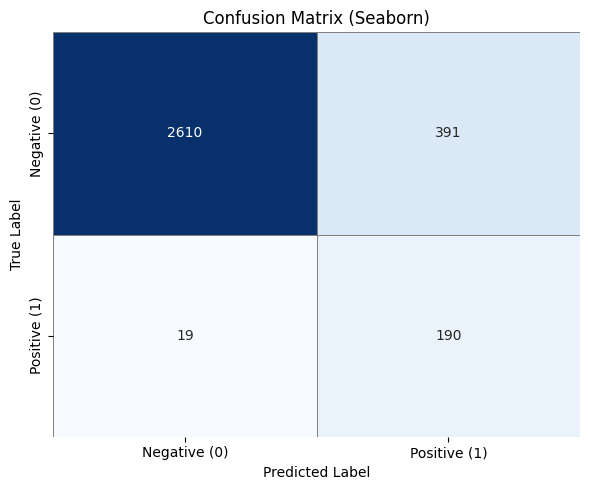

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_stacking)
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False)
plt.title("Confusion Matrix (Seaborn)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


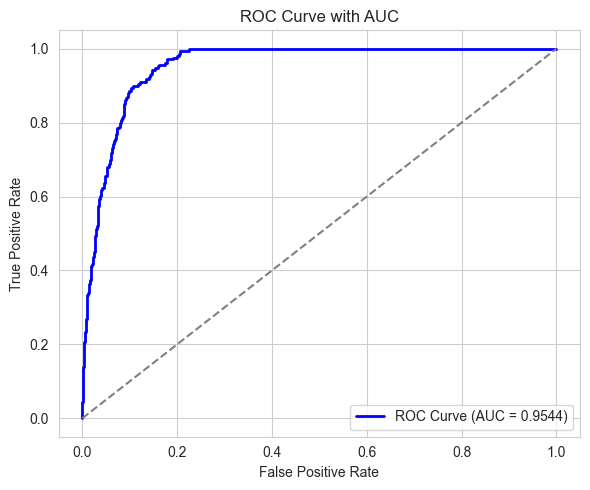

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba_stacking)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
